Описание проекта: 
    
    Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Описание данных

Данные лежат в файле taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [11]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [12]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


2. Анализ

In [17]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [19]:
df.rolling(10).mean()

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,NaN
2018-03-01 02:00:00,NaN
2018-03-01 03:00:00,NaN
2018-03-01 04:00:00,NaN
...,...
2018-08-31 19:00:00,166.6
2018-08-31 20:00:00,162.9
2018-08-31 21:00:00,162.1


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
decomposed = seasonal_decompose(df)

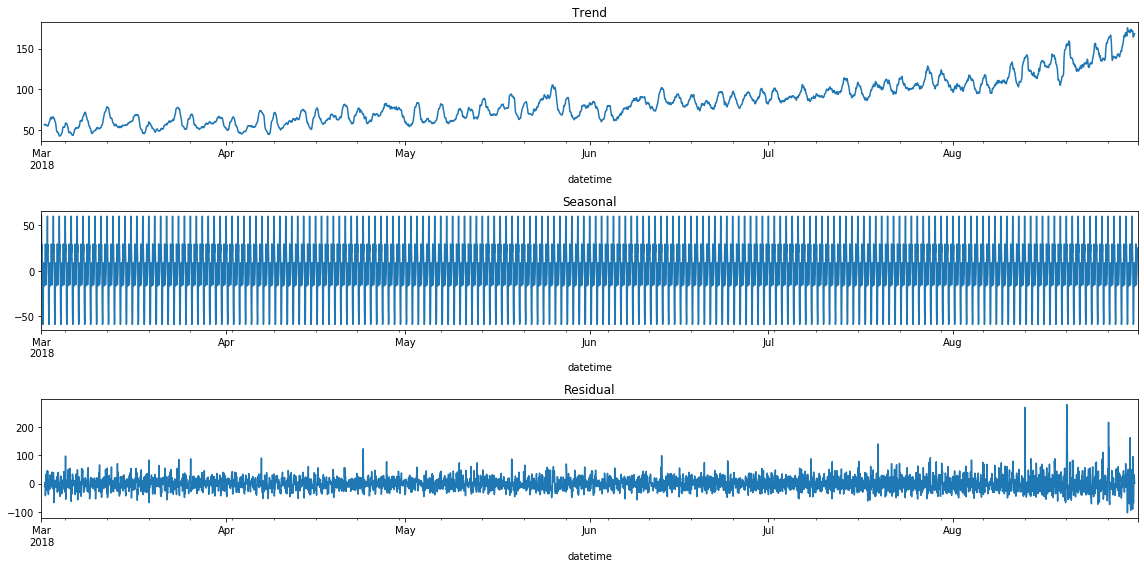

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.tight_layout()

In [31]:
def make_features(data, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for l in range(1,max_lag +1):
        df['lag_' + str(l)] = df['num_orders'].shift(l)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data
        

При разложении данных на составляющие (тренд, сезонность, остатки), из тренда заметны колебания в зависимости от дня недели, из составляющей сезонности - периодичность в рамках 24 часов: присутствуют выраженные пики и спады в количестве заказов. Остатки являются случайной компонентой, и значения похожи на шум, с увеличением дисперсии при увеличении составляющей тренда.

3. Обучение

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [37]:
make_features(df, 24, 12)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.416667
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.916667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.583333


In [46]:
df.dropna(inplace=True)

In [47]:
X = df.drop('num_orders',axis=1)
y = df['num_orders']
y = y.dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101, shuffle=False)

In [48]:
linreg = LinearRegression()

In [49]:
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
prediction_test = linreg.predict(X_test)
prediction_train = linreg.predict(X_train)

In [54]:
from sklearn.metrics import mean_squared_error as mse

In [63]:
prediction_previous = y_test.shift(fill_value=y_train.iloc[-1])  

In [58]:
print("RMSE обучающей выборки:", mse(y_train, prediction_train)**0.5)
print("RMSE тестовой выборки:", mse(y_test, prediction_test)**0.5)

RMSE обучающей выборки: 25.824713299765506
RMSE тестовой выборки: 45.54244745506206


In [64]:
print("RMSE тестовой выборки по предыдущему часу:", mse(y_test, prediction_previous)**0.5)

RMSE тестовой выборки по предыдущему часу: 58.881776776551476


Лучшая по метрике RMSE (на тестовой выборке ~45.15) модель основана на наборе параметров сдвига на 1-24 часа, а также скользящего среднего с окном в 12 часов.